In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import quandl
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLarsIC


QUESTION 1

Slope: 0.09324142754349984
Intercept: 0.0040478376866624555
R-squared: 0.0007049713034502621
Correlation Coefficient: 0.02655129570190996
P-value: 0.6409049000031647


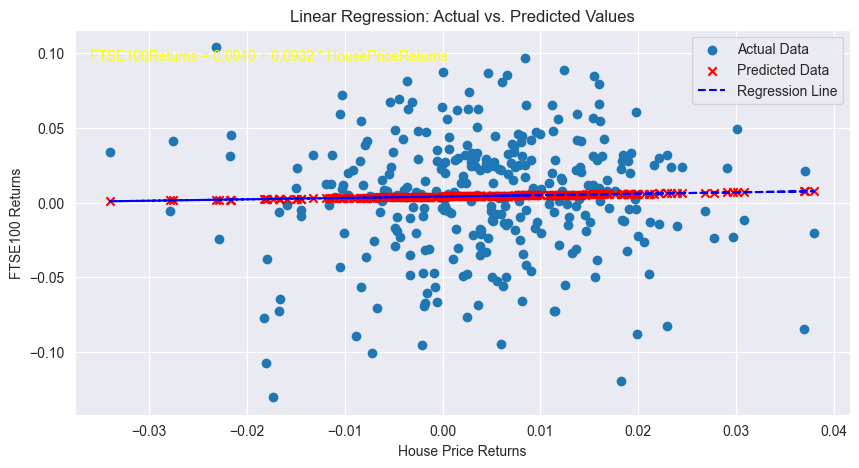

In [2]:
# Load the monthly house prices data and FTSE100 index data
data = pd.read_excel('Monthly.xls')
ftse_data = pd.read_csv('FTSE100.csv')

# Rename the columns
data = data.rename(columns={"Unnamed: 0": "Date", "Average House Price": "HousePrice"})

# Convert the 'Date' column to a datetime type
data['Date'] = pd.to_datetime(data['Date'])
ftse_data['Date'] = pd.to_datetime(ftse_data['Date'])

# Sort the DataFrame by the 'Date' column in ascending order
data.sort_values(by='Date', inplace=True)
ftse_data.sort_values(by='Date', inplace=True)

# Reset the index in ascending order
data.reset_index(drop=True, inplace=True)
ftse_data.reset_index(drop=True, inplace=True)

# Filter the FTSE100 data to match the date range (Jan 1991 - Dec 2016)
start_date = pd.to_datetime("1991-01-01")
end_date = pd.to_datetime("2016-12-31")

data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
ftse_data = ftse_data[(ftse_data['Date'] >= start_date) & (ftse_data['Date'] <= end_date)]

# Calculate the monthly returns for both variables
data['HousePriceReturns'] = data['HousePrice'].pct_change()
ftse_data['FTSE100Returns'] = ftse_data['Adj Close'].pct_change()

# Drop any rows with NaN values
ftse_data.dropna(subset=['FTSE100Returns'], inplace=True)
data.dropna(subset=['HousePriceReturns'], inplace=True)

# Use linregress for linear regression
slope, intercept, r_value, p_value, std_err = linregress(data['HousePriceReturns'], ftse_data['FTSE100Returns'])

# Calculate the correlation coefficient using numpy
correlation_coefficient = np.corrcoef(data['HousePriceReturns'], ftse_data['FTSE100Returns'])[0, 1]

# Print the results
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

# Calculate predicted values using the linear regression model
predicted_values = intercept + slope * data['HousePriceReturns']

# Create a scatter plot with predicted values
plt.figure(figsize=(10, 5))
plt.scatter(data['HousePriceReturns'], ftse_data['FTSE100Returns'], label='Actual Data')
plt.scatter(data['HousePriceReturns'], predicted_values, label='Predicted Data', marker='x', c='red')
plt.plot(data['HousePriceReturns'], intercept + slope * data['HousePriceReturns'], color='blue', linestyle='--', label='Regression Line')

# Add the linear regression equation for FTSE100Returns to the graph
ftse_equation = f'FTSE100Returns = {intercept:.4f} + {slope:.4f} * HousePriceReturns'
plt.annotate(ftse_equation, xy=(0.02, 0.92), xycoords='axes fraction', fontsize=10, color='yellow')

plt.xlabel('House Price Returns')
plt.ylabel('FTSE100 Returns')
plt.legend()
plt.title('Linear Regression: Actual vs. Predicted Values')
plt.show()


QUESTION 2

In [3]:
print("---------------------------------------------------------------------------")

print("--PART A--")

# Load the dataset
df = pd.read_csv('college.csv')

# Select the relevant columns
selected_columns = ['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc', 'Grad.Rate']
selected_data = df[selected_columns]

# Calculate correlation coefficients
correlation_matrix = selected_data.corr()
print(correlation_matrix)

print("---------------------------------------------------------------------------")

print("--PART B--")


# Define the target variable
target_variable = 'Grad.Rate'

# Define the candidate predictor variables
candidate_predictors = ['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc']

# Create the X (predictor variables) and y (target variable) data
X = df[candidate_predictors]
y = df[target_variable]

# Forward stepwise selection
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        if not changed:
            break
    return included

# Perform forward stepwise selection
selected_predictors = stepwise_selection(df[candidate_predictors], df[target_variable])

# Print the selected predictor variables
print("Selected Predictor Variables:")
print(selected_predictors)

# Build the final model using the selected predictors
final_model = sm.OLS(df[target_variable], sm.add_constant(df[selected_predictors])).fit()

# Print the summary of the final model
print(final_model.summary())

print("---------------------------------------------------------------------------")

print("--PART D--")
# Use LassoLarsIC for feature selection based on BIC
reg_lasso = LassoLarsIC(criterion='bic')
reg_lasso.fit(X, y)
lasso_bic_selected = X.columns[reg_lasso.coef_ != 0]

# Print the selected predictor variables based on BIC
print("Lasso BIC selected features:", list(lasso_bic_selected))

print("---------------------------------------------------------------------------")

print("--PART E--")


# Define useful predictors
useful_predictors = ['Outstate', 'Top25perc']

# Define all predictors
all_predictors = ['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc']

# Model 1: Using only useful predictors
X_useful = df[useful_predictors]
X_useful = sm.add_constant(X_useful)
y = df[target_variable]
model1 = sm.OLS(y, X_useful).fit()

# Model 2: Using all predictors
X_all = df[all_predictors]
X_all = sm.add_constant(X_all)
model2 = sm.OLS(y, X_all).fit()

# Calculate MSE for both models
y_pred1 = model1.predict(X_useful)
mse1 = mean_squared_error(y, y_pred1)
y_pred2 = model2.predict(X_all)
mse2 = mean_squared_error(y, y_pred2)

# Get R-squared values for both models
rsquared1 = model1.rsquared
rsquared2 = model2.rsquared

# Calculate the percentage of accuracy (R-squared as a percentage)
percentage_accuracy1 = rsquared1 * 100
percentage_accuracy2 = rsquared2 * 100

# Print the results
print("Model 1 (Useful Predictors) R-squared (Accuracy %):", percentage_accuracy1)
print("Model 2 (All Predictors) R-squared (Accuracy %):", percentage_accuracy2)

print("---------------------------------------------------------------------------")

print("--PART F--")

# Set the university name (Carnegie Mellon University)
university_name = "Carnegie Mellon University"

# Filter the dataset to get the row for Carnegie Mellon University
cmu_data = df[df['Unnamed: 0'] == university_name]

# Extract the relevant predictor variables for Carnegie Mellon University
X_cmu = cmu_data[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc']]
# Define the model parameters (model2.params)
intercept = model2.params.iloc[0]
coefficients = model2.params.iloc[1:]


# Calculate the predicted graduation rate
predicted_grad_rate = intercept + sum(coeff * val for coeff, val in zip(coefficients, X_cmu.values[0]))

# Print the predicted graduation rate for Carnegie Mellon University
print(f"Predicted Graduation Rate for {university_name}: {predicted_grad_rate:.2f}%")



---------------------------------------------------------------------------
--PART A--
               Apps    Enroll  Outstate  Top10perc  Top25perc  Grad.Rate
Apps       1.000000  0.846822  0.050159   0.338834   0.351640   0.146755
Enroll     0.846822  1.000000 -0.155477   0.181294   0.226745  -0.022341
Outstate   0.050159 -0.155477  1.000000   0.562331   0.489394   0.571290
Top10perc  0.338834  0.181294  0.562331   1.000000   0.891995   0.494989
Top25perc  0.351640  0.226745  0.489394   0.891995   1.000000   0.477281
Grad.Rate  0.146755 -0.022341  0.571290   0.494989   0.477281   1.000000
---------------------------------------------------------------------------
--PART B--
Add  Outstate                       with p-value 1.62893e-68
Add  Top25perc                      with p-value 4.69503e-15
Selected Predictor Variables:
['Outstate', 'Top25perc']
                            OLS Regression Results                            
Dep. Variable:              Grad.Rate   R-squared:        

QUESTION 4

In [4]:

# Replace 'YOUR_API_KEY' with your Quandl API key
quandl.ApiConfig.api_key = 'bghfK__Mrh5Vx2V22k5A'

# Download the data
data = quandl.get("ODA/ISR_LUR", start_date="1980-12-31", end_date="2013-09-02")

# Create a linear regression model
model = LinearRegression()

# Fit the model to your data
model.fit(data.index.year.values.reshape(-1, 1), data['Value'])

# Predict the unemployment rate in 2020
predicted_unemployment_rate = model.predict([[2020]])

print(f"Predicted unemployment rate in 2020: {predicted_unemployment_rate[0]:.2f}")

# Calculate MAPE
#y_true = data['Value']
#y_pred = model.predict(data.index.year.values.reshape(-1, 1)).flatten()
#mape = mean_absolute_error(y_true, y_pred) / np.mean(y_true) * 100
# Calculate MAPE
y_true = data['Value']

y_pred = model.predict(data.index.year.values.reshape(-1, 1)).flatten()

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAPE: {mape:.2f}%")



Predicted unemployment rate in 2020: 12.08
MAPE: 21.99%


QUESTION 3

Correlation Coefficient: 0.03670426761939606
                            OLS Regression Results                            
Dep. Variable:      transport_service   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2968
Date:                Wed, 25 Oct 2023   Prob (F-statistic):              0.586
Time:                        23:13:21   Log-Likelihood:                -915.37
No. Observations:                 222   AIC:                             1835.
Df Residuals:                     220   BIC:                             1842.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

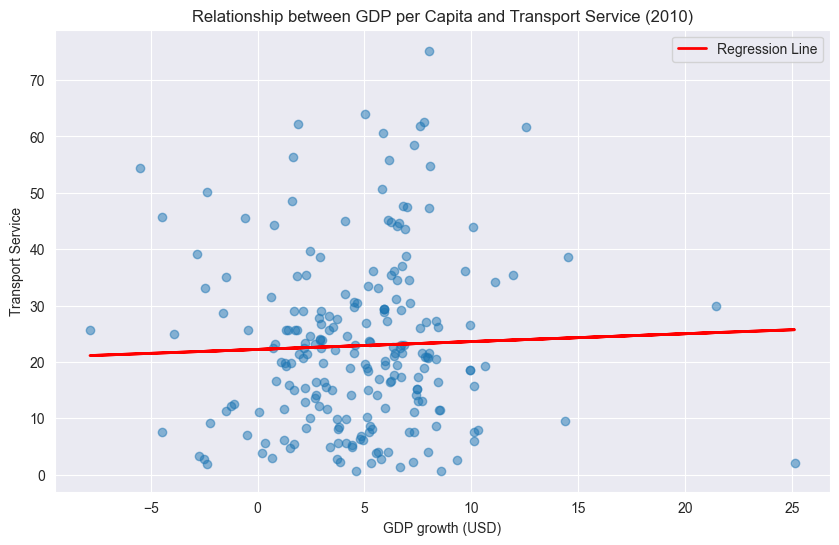

Correlation Coefficient: 0.03670426761939606
Mean GDP growth (USD): 4.698233703798777
Median GDP growth (USD): 5.04421870095976
Standard Deviation of GDP growth (USD): 3.9515126406196726
Mean transport_service: 22.87181226684209
Median transport_service: 21.201167455862603
Standard Deviation of transport_service: 14.988296948968399
Top Performers (Highest transport_service):
    Country Name  transport_service  GDP growth (USD)
145      Nigeria          75.201618          8.005656
110        Libya          64.008778          5.027248
21       Belarus          62.495311          7.798267
47       Denmark          62.171667          1.870991
211   Uzbekistan          61.762222          7.597168
Bottom Performers (Lowest transport_service):
              Country Name  transport_service  GDP growth (USD)
144                  Niger           0.699562          8.578167
73           Guinea-Bissau           0.729927          4.610971
182  Sao Tome and Principe           1.342267          6.671

In [5]:

# Loading the dataset
tranport_data = pd.read_csv('transport_service.csv', skiprows=3)
GDP_growth = pd.read_csv('gdp_growth.csv', skiprows=3)

# Filter the data for the year 2010
transport_data_2010 = tranport_data[['Country Name', '2010']].dropna()
GDP_growth_2010 = GDP_growth[['Country Name', '2010']].dropna()

# Merge the dataframes on 'Country Name'
merged_df = pd.merge(transport_data_2010, GDP_growth_2010, on='Country Name', how='inner')

# Rename columns for clarity
merged_df.columns = ['Country Name', 'transport_service', 'GDP growth (USD)']

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['GDP growth (USD)'], merged_df['transport_service'], alpha=0.5)
plt.title('Relationship between GDP per Capita and Transport Service (2010)')
plt.xlabel('GDP growth (USD)')
plt.ylabel('Transport Service')
plt.grid(True)

# Fit a linear regression model
X = sm.add_constant(merged_df['GDP growth (USD)'])
model = sm.OLS(merged_df['transport_service'], X).fit()
regression_line = model.params['GDP growth (USD)'] * merged_df['GDP growth (USD)'] + model.params['const']
plt.plot(merged_df['GDP growth (USD)'], regression_line, color='red', linewidth=2, label='Regression Line')
plt.legend()

# Calculate the correlation coefficient
correlation_coefficient = merged_df['GDP growth (USD)'].corr(merged_df['transport_service'])
print(f'Correlation Coefficient: {correlation_coefficient}')

# Hypothesis test for the significance of the relationship
print(model.summary())
# Show the plot with the regression line
plt.show()

# Calculate summary statistics
mean_gdp = merged_df['GDP growth (USD)'].mean()
median_gdp = merged_df['GDP growth (USD)'].median()
std_gdp = merged_df['GDP growth (USD)'].std()

mean_deaths = merged_df['transport_service'].mean()
median_deaths = merged_df['transport_service'].median()
std_deaths = merged_df['transport_service'].std()

# Identify top and bottom performers
top_performers = merged_df.nlargest(5, 'transport_service')
bottom_performers = merged_df.nsmallest(5, 'transport_service')

print(f'Correlation Coefficient: {correlation_coefficient}')
print(f'Mean GDP growth (USD): {mean_gdp}')
print(f'Median GDP growth (USD): {median_gdp}')
print(f'Standard Deviation of GDP growth (USD): {std_gdp}')
print(f'Mean transport_service: {mean_deaths}')
print(f'Median transport_service: {median_deaths}')
print(f'Standard Deviation of transport_service: {std_deaths}')
print('Top Performers (Highest transport_service):')
print(top_performers)
print('Bottom Performers (Lowest transport_service):')
print(bottom_performers)


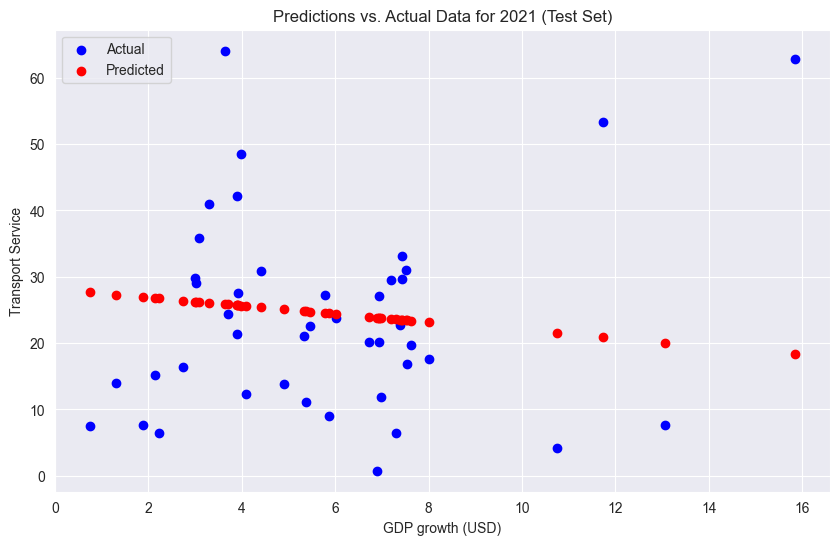

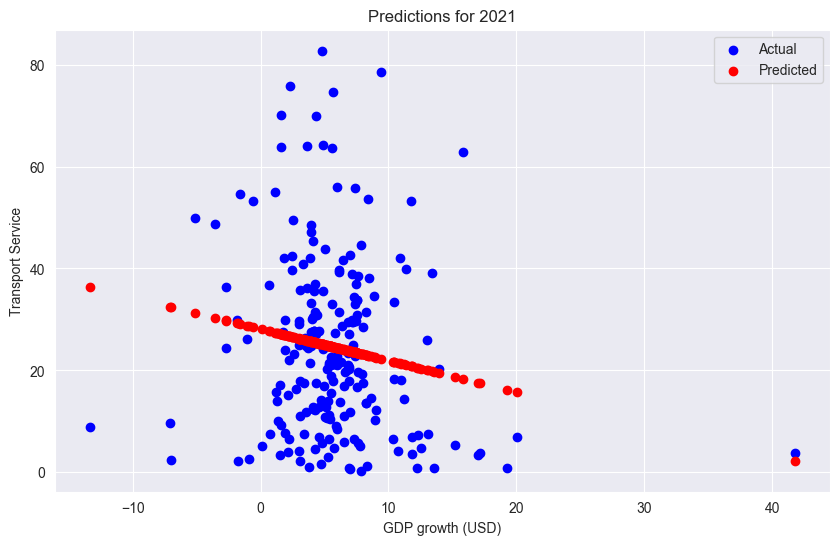

Mean Absolute Error (MAE): 11.495108914847748
Mean Squared Error (MSE): 227.76855495258704
R-squared (R2) Score: -0.06714830473900602


In [6]:
# Filter road traffic deaths for 2021
tranport_data_2021 = tranport_data[['Country Name', '2021']].dropna()
# Filter GDP per capita for 2021
GDP_growth_2021 = GDP_growth[['Country Name', '2021']].dropna()
# Merge the 2021 dataframes on 'Country Name'
merged_2021_df = pd.merge(tranport_data_2021, GDP_growth_2021, on='Country Name', how='inner')

# Rename columns for clarity
merged_2021_df.columns = ['Country Name', 'tranport_service_2021', 'GDP_growth(USD)_2021']

# Extract the features (GDP growth) and target variable (transport service for 2021)
X = merged_2021_df[['GDP_growth(USD)_2021']]
y = merged_2021_df['tranport_service_2021']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions for the test set
predictions = model.predict(X_test)

# Calculate evaluation metrics for the test set
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Visualize the predictions and actual data for the test set
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='b', label='Actual')
plt.scatter(X_test, predictions, color='r', label='Predicted')
plt.xlabel('GDP growth (USD)')
plt.ylabel('Transport Service')
plt.title('Predictions vs. Actual Data for 2021 (Test Set)')
plt.legend()
plt.show()

# Make predictions for 2021 using full 2021 dataset
predictions_2021 = model.predict(X)

# Visualize the predictions for 2021
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='b', label='Actual')
plt.scatter(X, predictions_2021, color='r', label='Predicted')
plt.xlabel('GDP growth (USD)')
plt.ylabel('Transport Service')
plt.title('Predictions for 2021')
plt.legend()
plt.show()

# Print the model's performance metrics for the test set
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

